In [1]:
import geopandas as gpd

gdf = gpd.read_file('/data/private/BreizhCrops/experiments/training_results/main/0-baseline/0-baseline_model_accuracies.geojson')
gdf2 = gpd.read_file('geojsons/merged_data.geojson')

        id CODE_CULTU                   path     meanCLD  sequencelength  \
0  5767259        LUZ  csv/frh01/5767259.csv  756.651308              50   
1  6017304        BTA  csv/frh01/6017304.csv  737.280000              50   
2  6017310        CZH  csv/frh01/6017310.csv  710.327555              50   
3  6017311        BTH  csv/frh01/6017311.csv  717.753189              50   
4  6017312        PPR  csv/frh01/6017312.csv  696.743646              50   

   classid      classname region          area   perimeter  \
0        3         fodder  frh01   9413.269572  414.933542   
1        5  miscellaneous  frh01   1665.638609  184.212032   
2       10       rapeseed  frh01  41233.158559  836.705857   
3        1   common wheat  frh01  34646.521324  754.644773   
4        9  protein crops  frh01  31913.064203  802.174602   

   area_perimeter_ratio  distance_to_closest_city  Field_ID  True_Label  \
0             22.686210              17157.706374   5767259           3   
1              9.041

In [13]:
gdf2 = gpd.read_file('geojsons/merged_data.geojson')

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
import os

def analyze_attribute_influence(gdf, attribute, num_bins):
    # Set the path for saving CSVs
    save_path = "/data/private/BreizhCrops/experiments/sensitive_attribute_identification/heatmaps"
    os.makedirs(save_path, exist_ok=True)
    
    # Filter to only the testing set (frh04)
    testing_set = gdf[gdf['Dataset'] == 'frh04']
    
    # Ensure the attribute column is numeric, coercing errors to NaN
    testing_set[attribute] = pd.to_numeric(testing_set[attribute], errors='coerce')

    # Ensure 'True_Label' and 'Predicted_Label' are integer types
    testing_set['True_Label'] = testing_set['True_Label'].astype(int)
    testing_set['Predicted_Label'] = testing_set['Predicted_Label'].astype(int)

    # Get the unique classes
    unique_classes = np.unique(testing_set['True_Label'])

    # Replace the classname for class ID 4 with 'fallow'
    gdf['classname'] = gdf.apply(lambda row: 'fallow' if row['True_Label'] == 4 else row['classname'], axis=1)

    # Create a dictionary to map class IDs to class names
    class_id_to_name = gdf.set_index('True_Label')['classname'].to_dict()

    def calculate_f1_for_bins(data, attribute, num_bins, unique_classes):
        # Create equal-sized bins for the attribute
        data[f'{attribute}_bin'] = pd.qcut(data[attribute], num_bins, duplicates='drop')

        # Initialize the result array
        f1_results = np.zeros((len(data[f'{attribute}_bin'].cat.categories), len(unique_classes) + 1))

        # Calculate F1 score for each bin
        for i, bin_label in enumerate(data[f'{attribute}_bin'].cat.categories):
            bin_data = data[data[f'{attribute}_bin'] == bin_label]

            # Calculate F1 score for each class
            f1_scores = f1_score(bin_data['True_Label'], bin_data['Predicted_Label'], labels=unique_classes, average=None, zero_division=0)
            
            # Calculate macro-average F1 score (across all classes)
            macro_f1 = f1_score(bin_data['True_Label'], bin_data['Predicted_Label'], average='macro', zero_division=0)

            # Store class-specific F1 scores
            f1_results[i, :-1] = f1_scores
            # Append the macro F1 score as the last column
            f1_results[i, -1] = macro_f1

        return f1_results, data[f'{attribute}_bin'].cat.categories

    # Get the F1 scores and bin labels
    f1_results, bin_labels = calculate_f1_for_bins(testing_set, attribute, num_bins, unique_classes)

    # Convert class IDs to class names, using the dictionary created earlier
    class_names = [class_id_to_name[class_id] for class_id in unique_classes] + ['Macro F1']

    # Create a DataFrame for saving
    f1_df = pd.DataFrame(f1_results, columns=class_names)
    f1_df.index = bin_labels

    # Save the heatmap data as CSV
    csv_filename = f'{attribute}_f1_heatmap.csv'
    f1_df.to_csv(os.path.join(save_path, csv_filename))

    # Plot heatmap for F1 scores
    plt.figure(figsize=(12, 6))  # Adjusted size to accommodate the additional column
    sns.heatmap(f1_df, annot=True, fmt=".2f", cmap='viridis')
    plt.title(f'F1 Scores by {attribute} Bin and Class')
    plt.ylabel(f'{attribute} Bin')
    plt.xlabel('Class / Macro F1')
    plt.show()



In [30]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
import os

def analyze_chemical_influence(gdf1, gdf2):
    # Set the path for saving CSVs
    save_path = "/data/private/BreizhCrops/experiments/sensitive_attribute_identification/heatmaps"
    os.makedirs(save_path, exist_ok=True)

    # Merge on 'id'
    merged_gdf = gdf1.merge(gdf2, on='id')
    
    # Keep only one set of redundant columns and rename chemical attributes to have a common prefix if necessary
    chemical_attributes = [col for col in merged_gdf.columns if col.startswith('mean_')]
    class_columns = ['id', 'True_Label', 'Predicted_Label', 'Dataset'] + chemical_attributes
    merged_gdf = merged_gdf[class_columns]
    
    # Convert labels to integers
    merged_gdf['True_Label'] = merged_gdf['True_Label'].astype(int)
    merged_gdf['Predicted_Label'] = merged_gdf['Predicted_Label'].astype(int)
    
    # Filter data to only focus on the testing set
    testing_set = merged_gdf[merged_gdf['Dataset'] == 'frh04']
    
    # Get unique classes
    unique_classes = merged_gdf['True_Label'].unique()

    def calculate_f1_for_bins(data, chemical_attributes, unique_classes):
        # Store results in a dictionary
        metrics_results = {}

        for attribute in chemical_attributes:
            print(testing_set[attribute].nunique())  # Replace 'mean_CaCO' with the actual attribute name
            # Create 20 equally spaced bins for each chemical property using pd.cut
            print(attribute)
            data[f'{attribute}_bin'] = pd.qcut(data[attribute], 20, duplicates='drop')
            
            testing_set[attribute] = pd.to_numeric(testing_set[attribute], errors='coerce')

            # Initialize the result array
            f1_results = np.zeros((len(data[f'{attribute}_bin'].cat.categories), len(unique_classes) + 1))

            # Calculate F1 score for each bin
            for i, bin_label in enumerate(data[f'{attribute}_bin'].cat.categories):
                bin_data = data[data[f'{attribute}_bin'] == bin_label]

                # Calculate F1 score for each class
                f1_scores = f1_score(bin_data['True_Label'], bin_data['Predicted_Label'], labels=unique_classes, average=None, zero_division=0)
                
                # Calculate macro-average F1 score (across all classes)
                macro_f1 = f1_score(bin_data['True_Label'], bin_data['Predicted_Label'], average='macro', zero_division=0)

                # Store class-specific F1 scores
                f1_results[i, :-1] = f1_scores
                # Append the macro F1 score as the last column
                f1_results[i, -1] = macro_f1

            # Add results to the metrics_results dictionary
            metrics_results[f'{attribute}_f1'] = f1_results

        # After collecting all metrics, create heatmaps and save CSVs
        for attribute in chemical_attributes:
            f1_df = pd.DataFrame(metrics_results[f'{attribute}_f1'], columns=list(unique_classes) + ['Macro F1'])
            f1_df.index = data[f'{attribute}_bin'].cat.categories

            # Save the heatmap data as CSV
            csv_filename = f'{attribute}_f1_heatmap.csv'
            f1_df.to_csv(os.path.join(save_path, csv_filename))

            # Plotting heatmap for F1 scores
            plt.figure(figsize=(12, 6))  # Adjusted size to accommodate the additional column
            sns.heatmap(f1_df, annot=True, fmt=".2f", cmap='viridis')
            plt.title(f'F1 Scores by {attribute} Bin and Class (Including Macro F1)')
            plt.ylabel(f'{attribute} Bin')
            plt.xlabel('Class ID / Macro F1')
            plt.show()

    # Call the function for testing set only
    print("\nTesting Set Metrics (F1 Scores):")
    calculate_f1_for_bins(testing_set, chemical_attributes, unique_classes)


/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


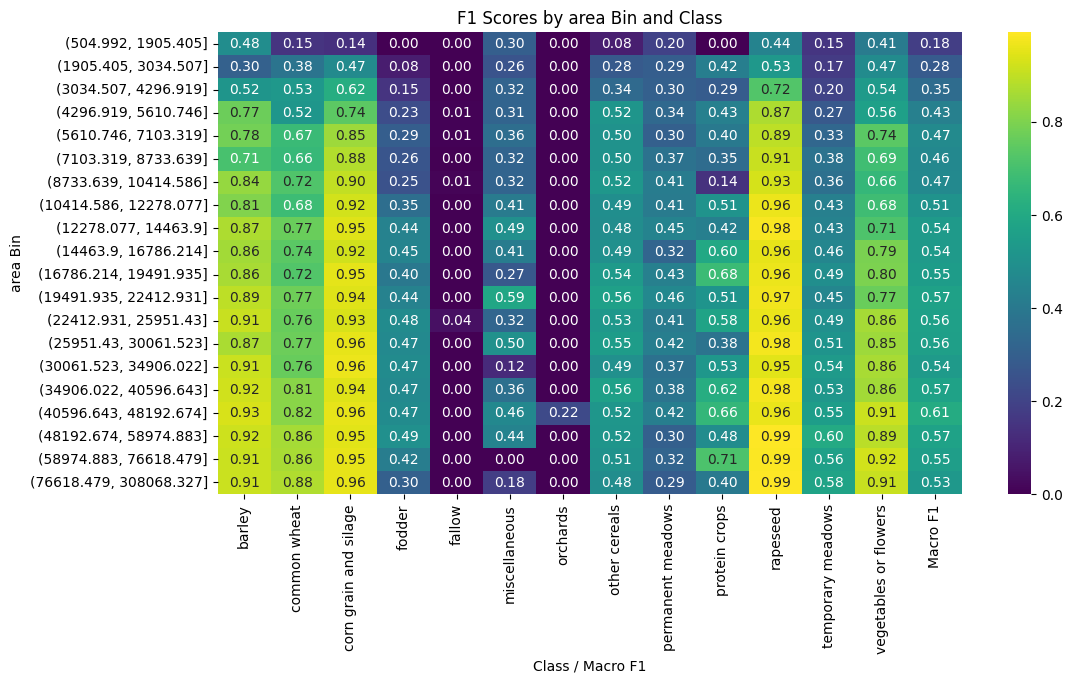

In [18]:
analyze_attribute_influence(gdf, 'area', 20)

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


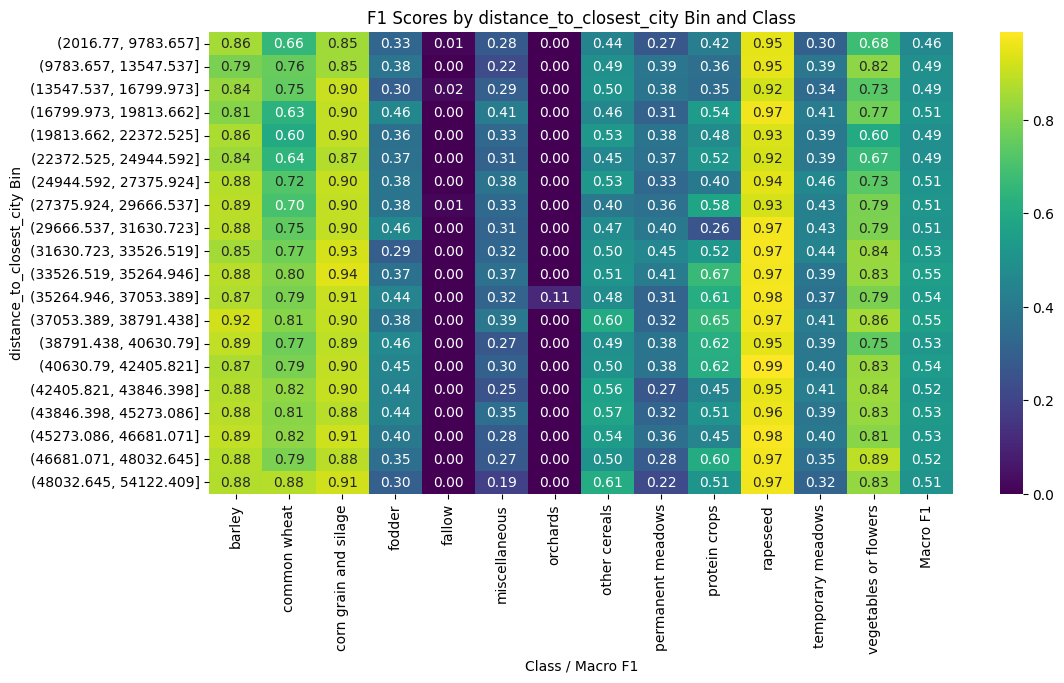

In [19]:
analyze_attribute_influence(gdf, 'distance_to_closest_city', 20)


Testing Set Metrics (F1 Scores):
16428
mean_CEC
16426
mean_N


/tmp/ipykernel_1582/485306435.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{attribute}_bin'] = pd.qcut(data[attribute], 20, duplicates='drop')
/tmp/ipykernel_1582/485306435.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set[attribute] = pd.to_numeric(testing_set[attribute], errors='coerce')
/tmp/ipykernel_1582/485306435.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

16336
mean_pH_H2O_CaCl
16405
mean_pH_CaCl


/tmp/ipykernel_1582/485306435.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{attribute}_bin'] = pd.qcut(data[attribute], 20, duplicates='drop')
/tmp/ipykernel_1582/485306435.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set[attribute] = pd.to_numeric(testing_set[attribute], errors='coerce')
/tmp/ipykernel_1582/485306435.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

16408
mean_pH_H2O
16420
mean_CN


/tmp/ipykernel_1582/485306435.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{attribute}_bin'] = pd.qcut(data[attribute], 20, duplicates='drop')
/tmp/ipykernel_1582/485306435.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set[attribute] = pd.to_numeric(testing_set[attribute], errors='coerce')
/tmp/ipykernel_1582/485306435.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

11646
mean_CaCO3


/tmp/ipykernel_1582/485306435.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{attribute}_bin'] = pd.qcut(data[attribute], 20, duplicates='drop')
/tmp/ipykernel_1582/485306435.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set[attribute] = pd.to_numeric(testing_set[attribute], errors='coerce')


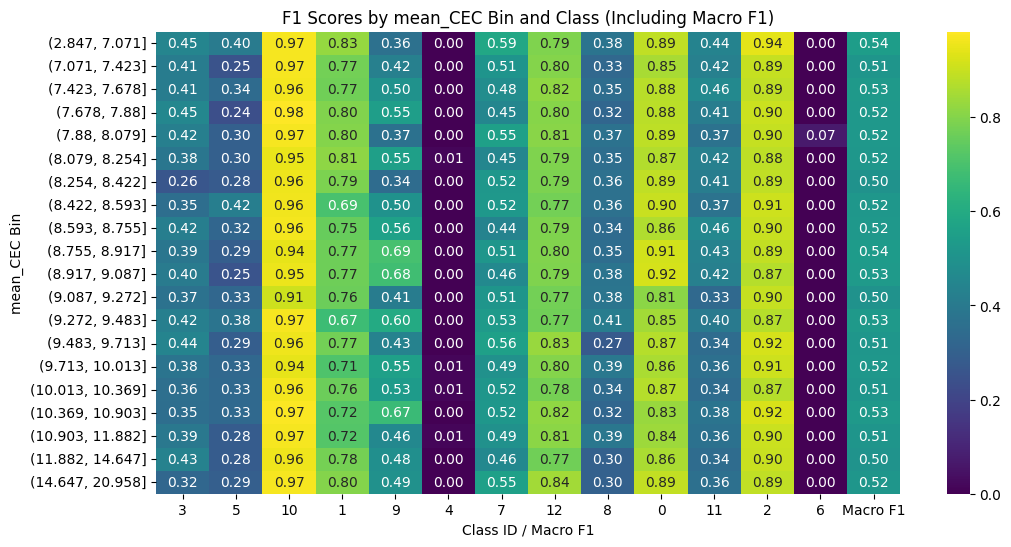

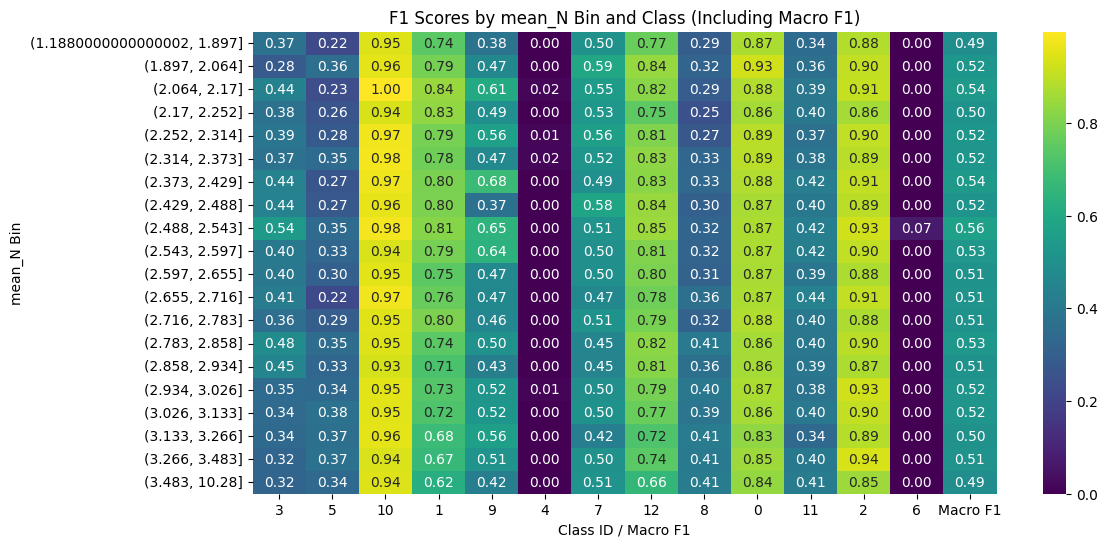

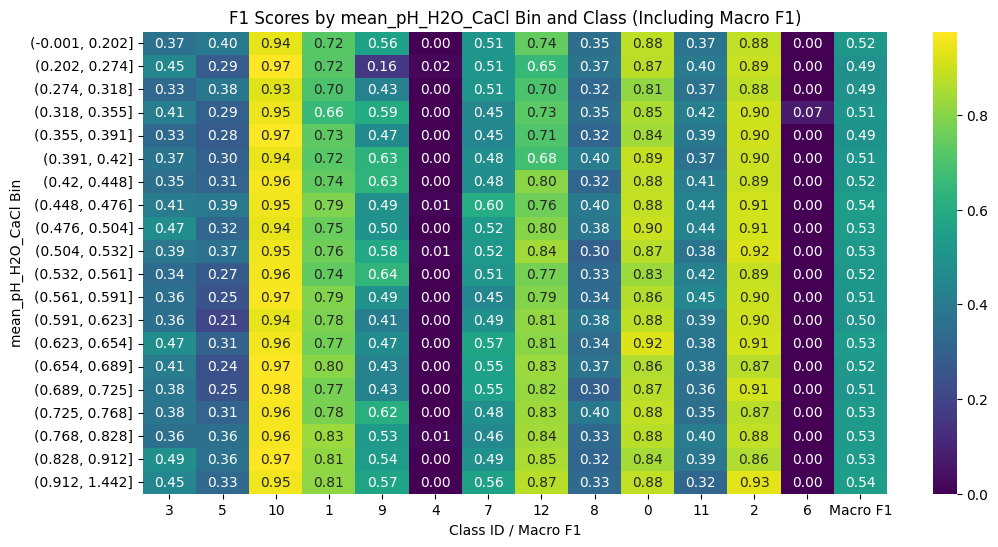

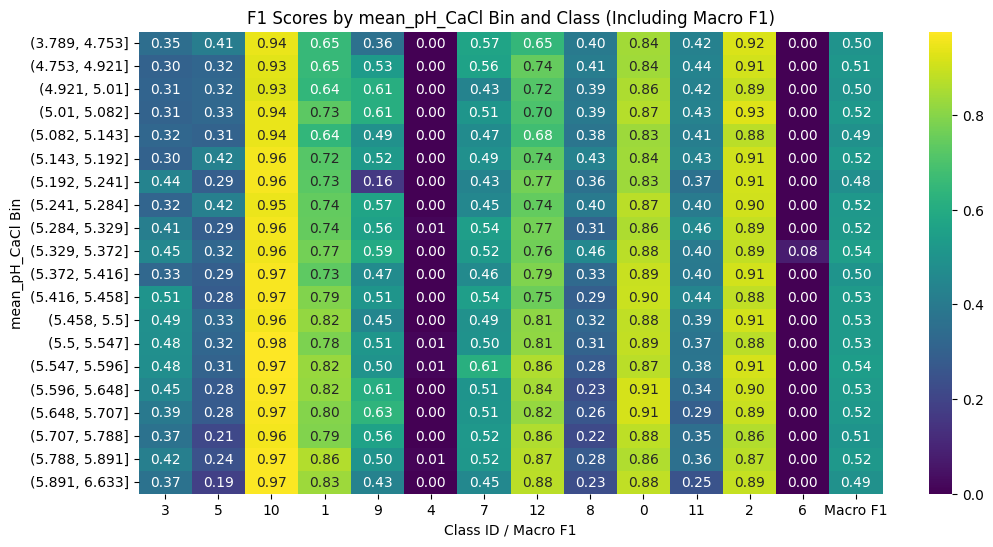

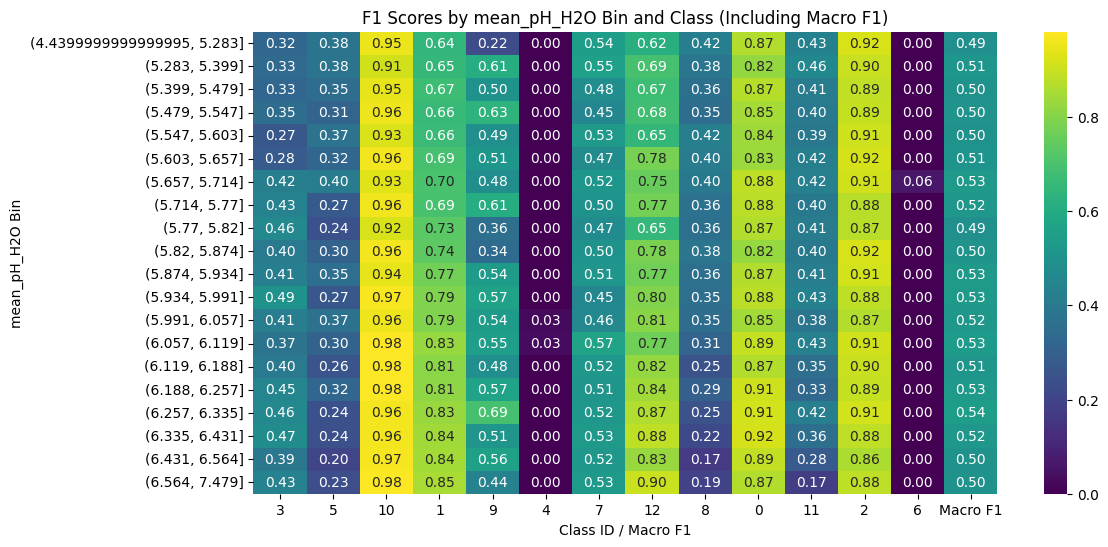

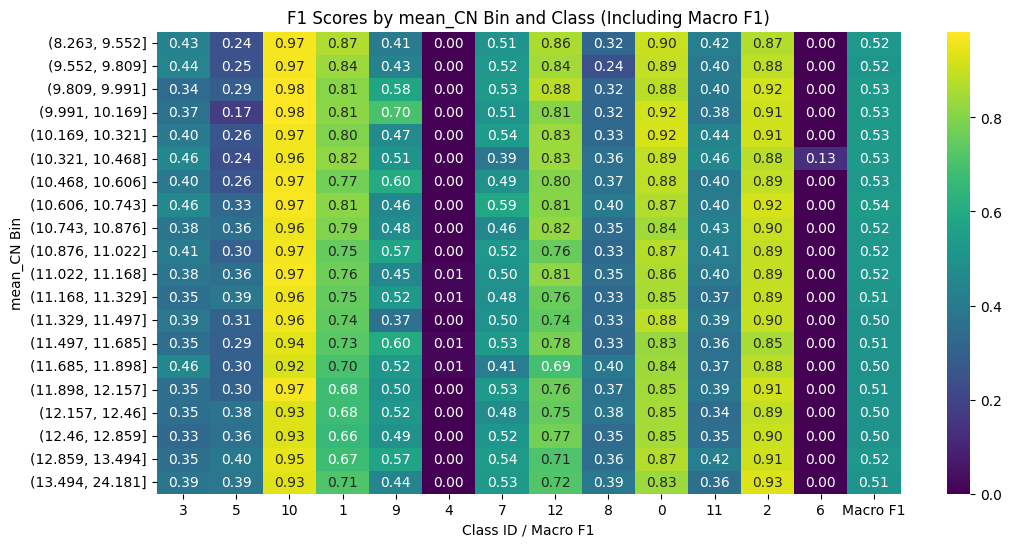

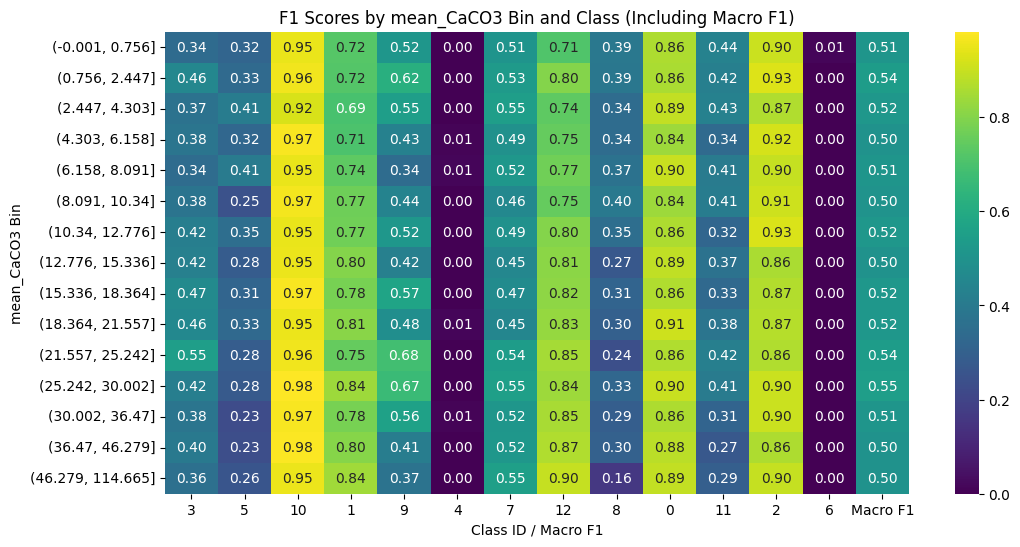

In [31]:
analyze_chemical_influence(gdf, gdf2)

In [33]:
import os
import pandas as pd

# Path to the directory where the CSV files are stored
csv_directory = "/data/private/BreizhCrops/experiments/sensitive_attribute_identification/heatmaps"
# Path to save the consolidated CSV
output_csv = "/data/private/BreizhCrops/experiments/sensitive_attribute_identification/consolidated_macro_f1_scores.csv"

def get_ranges_and_macro_f1(csv_directory):
    # Dictionary to store the ranges and macro F1 scores for each attribute
    results = {}

    # Loop through all CSV files in the directory
    for filename in os.listdir(csv_directory):
        if filename.endswith('.csv'):
            # Get the attribute name from the filename
            attribute_name = filename.replace('_f1_heatmap.csv', '')

            # Load the CSV file into a DataFrame
            filepath = os.path.join(csv_directory, filename)
            df = pd.read_csv(filepath, index_col=0)

            # Get the bin ranges (these are stored in the index)
            bin_ranges = df.index.tolist()

            # Get the Macro F1 scores (these are in the last column)
            macro_f1_scores = df['Macro F1'].tolist()

            # Store the ranges and macro F1 scores in the results dictionary
            results[attribute_name] = {
                'ranges': bin_ranges,
                'macro_f1_scores': macro_f1_scores
            }

    return results

def save_consolidated_results(results, output_csv):
    # Create a DataFrame to consolidate all results
    consolidated_df = pd.DataFrame()

    # Loop through the results dictionary and append data to the DataFrame
    for attribute, data in results.items():
        # Create a temporary DataFrame for each attribute
        temp_df = pd.DataFrame({
            'Range': data['ranges'],
            f'{attribute}_Macro_F1': data['macro_f1_scores']
        })
        
        # Append the temp_df to the consolidated DataFrame
        if consolidated_df.empty:
            consolidated_df = temp_df
        else:
            consolidated_df = pd.concat([consolidated_df, temp_df], axis=1)

    # Save the consolidated DataFrame to a CSV file
    consolidated_df.to_csv(output_csv, index=False)
    print(f"Consolidated CSV saved at {output_csv}")

# Run the functions
results = get_ranges_and_macro_f1(csv_directory)
save_consolidated_results(results, output_csv)


Consolidated CSV saved at /data/private/BreizhCrops/experiments/sensitive_attribute_identification/consolidated_macro_f1_scores.csv


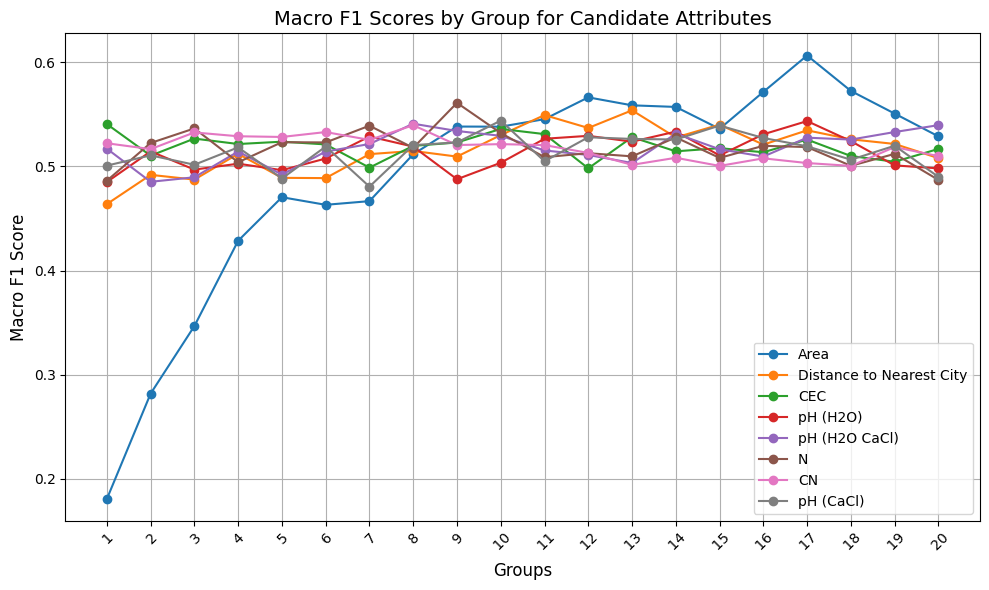

In [38]:
def plot_macro_f1_scores(file_path, save_path=None):
    """
    Function to plot macro F1 scores for different attributes across value ranges and optionally save the plot.
    
    Args:
    file_path (str): The path to the CSV file containing the macro F1 scores.
    save_path (str, optional): The path to save the plot as an SVG file. If None, the plot will not be saved.
    
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Load the CSV file
    df = pd.read_csv(file_path)

    # Extract the groups and the relevant attributes to plot
    groups = [f' {i+1}' for i in range(len(df))]
    
    # Define the relevant attributes to plot
    area_f1 = df['area_Macro_F1']
    distance_f1 = df['distance_to_closest_city_Macro_F1']
    cec_f1 = df['mean_CEC_Macro_F1']
    ph_h2o_f1 = df['mean_pH_H2O_Macro_F1']
    ph_h2o_cacl_f1 = df['mean_pH_H2O_CaCl_Macro_F1']
    n_f1 = df['mean_N_Macro_F1']
    cn_f1 = df['mean_CN_Macro_F1']
    ph_cacl_f1 = df['mean_pH_CaCl_Macro_F1']
    
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot the data
    plt.plot(groups, area_f1, label='Area', marker='o')
    plt.plot(groups, distance_f1, label='Distance to Nearest City', marker='o')
    plt.plot(groups, cec_f1, label='CEC', marker='o')
    plt.plot(groups, ph_h2o_f1, label='pH (H2O)', marker='o')
    plt.plot(groups, ph_h2o_cacl_f1, label='pH (H2O CaCl)', marker='o')
    plt.plot(groups, n_f1, label='N', marker='o')
    plt.plot(groups, cn_f1, label='CN', marker='o')
    plt.plot(groups, ph_cacl_f1, label='pH (CaCl)', marker='o')

    # Add labels and title
    plt.xlabel('Groups', fontsize=12)
    plt.ylabel('Macro F1 Score', fontsize=12)
    plt.title('Macro F1 Scores by Group for Candidate Attributes', fontsize=14)

    # Add a legend
    plt.legend()

    # Save the plot as an SVG file if a save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')
    
    # Display the plot
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_macro_f1_scores('/data/private/BreizhCrops/experiments/sensitive_attribute_identification/consolidated_macro_f1_scores.csv', '/data/private/BreizhCrops/experiments/sensitive_attribute_identification/plot.svg')
